In [12]:
import numpy as np
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data
import nnfs

nnfs.init()

# Data Sample

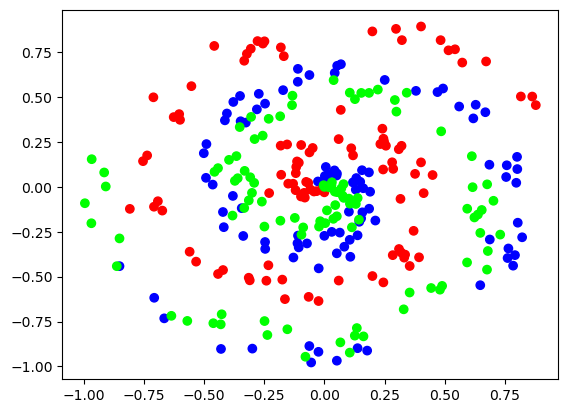

In [135]:
x, y = spiral_data(samples=100, classes=3)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap='brg')
plt.show()

# Neural Network

## Layers

In [14]:
class Layer:
    def __init__(self):
        self.inputs = np.array([])
        self.weights = np.array([])
        self.biases = np.array([])
        self.outputs = np.array([])
        
        self.inputs_prime = np.array([])
        self.weights_prime = np.array([])
        self.biases_prime = np.array([])
        self.outputs_prime = np.array([])
        
        self.loss = CategoricalCrossentropy()
        self.accuracy = 0.0

    def forward(self, inputs: np.ndarray) -> np.ndarray:
        pass

    def backward(self, outputs_prime: np.ndarray) -> np.ndarray:
        pass

    def get_loss(self, y_true) -> float:
        return self.loss.calculate(self.outputs, y_true)
    
    def layer_accuracy(self, y_true) -> float:
        predictions = np.argmax(self.outputs, axis=1)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.accuracy = np.mean(predictions == y_true)
        
        return self.accuracy

### Dense Layer

In [15]:
class DenseLayer(Layer):
    def __init__(self, n_inputs: int, n_neurons: int):
        super().__init__()

        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs: np.ndarray) -> np.ndarray:
        self.inputs = inputs
        self.outputs = np.dot(inputs, self.weights) + self.biases

        return self.outputs

    def backward(self, outputs_prime: np.ndarray) -> np.ndarray:
        self.outputs_prime = outputs_prime.copy()
        self.weights_prime = np.dot(self.inputs.T, outputs_prime)
        self.biases_prime = np.sum(outputs_prime, axis=0, keepdims=True)
        self.inputs_prime = np.dot(outputs_prime, self.weights.T)

        return self.inputs_prime

### Activation Layer

In [16]:
class ActivationLayer(Layer):
    def __init__(self, activation_function, activation_function_prime):
        super().__init__()
        
        self.activation_function = activation_function
        self.activation_function_prime = activation_function_prime
        
    def forward(self, inputs: np.ndarray) -> np.ndarray:
        self.inputs = inputs
        self.outputs = self.activation_function(self.inputs)
        
        return self.outputs
    
    def backward(self, outputs_prime: np.ndarray) -> np.ndarray:
        self.outputs_prime = outputs_prime.copy()
        return self.activation_function_prime(self.outputs_prime)

    def loss_backward(self, outputs_prime, y_true):
        samples = len(outputs_prime)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
            
        self.inputs_prime = outputs_prime.copy()
        self.inputs_prime[range(samples), y_true] -= 1
        self.inputs_prime /= samples
        
        return self.inputs_prime


class ActivationReLU(ActivationLayer):
    def __init__(self):
        def activation_function(inputs: np.ndarray) -> np.ndarray:
            self.inputs = inputs
            self.outputs = np.maximum(0, inputs)
            
            return self.outputs
        
        def activation_function_prime(outputs_prime: np.ndarray) -> np.ndarray:
            self.outputs_prime = outputs_prime.copy()
            self.inputs_prime = outputs_prime.copy()
            self.inputs_prime[self.inputs <= 0] = 0

            return self.inputs_prime
        
        super().__init__(activation_function, activation_function_prime)


class ActivationSoftmax(ActivationLayer):
    def __init__(self):
        def activation_function(inputs: np.ndarray) -> np.ndarray:
            self.inputs = inputs
            
            exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
            self.outputs =  exp_values / np.sum(exp_values, axis=1, keepdims=True)
            
            return self.outputs

        def activation_function_prime(outputs_prime: np.ndarray) -> np.ndarray:
            self.outputs_prime = outputs_prime.copy()
            self.inputs_prime = np.empty_like(outputs_prime)

            for index, (single_output, single_output_prime) in enumerate(zip(self.outputs, outputs_prime)):
                single_output = single_output.reshape(-1, 1)
                jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

                self.inputs_prime[index] = np.dot(jacobian_matrix, single_output_prime)

            return self.inputs_prime

        super().__init__(activation_function, activation_function_prime)

### Loss

In [17]:
class Loss:
    def forward(self, y_pred, y_true):
        pass
    
    def backward(self, outputs_prime, y_true):
        pass

    def calculate(self, y_pred, y_true) -> float:
        sample_losses = self.forward(y_pred, y_true)
        data_loss = np.mean(sample_losses)
        return data_loss
    
    
class CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true) -> np.ndarray:
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        correct_confidences = np.array([])
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )
        
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self, outputs_prime, y_true):
        samples = len(outputs_prime)
        labels = len(outputs_prime[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
            
        inputs_prime = (-y_true / outputs_prime) / samples
        return inputs_prime

## Optimizers

### Stochastic Gradient Descent (SGD)

In [18]:
class OptimizerSGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
        
    def update_params(self, layer: Layer):
        if self.momentum:
            if not hasattr(layer, 'weights_momentum'):
                layer.weights_momentum = np.zeros_like(layer.weights)
                layer.biases_momentum = np.zeros_like(layer.biases)
            
            weights_update = self.momentum * layer.weights_momentum - self.current_learning_rate * layer.weights_prime
            layer.weights_momentum = weights_update
            
            biases_update = self.momentum * layer.biases_momentum - self.current_learning_rate * layer.biases_prime
            layer.biases_momentum = biases_update
        
        else:
            weights_update = -self.current_learning_rate * layer.weights_prime
            biases_update = -self.current_learning_rate * layer.biases_prime
            
        layer.weights += weights_update
        layer.biases += biases_update
        
    def post_update_params(self):
        self.iterations += 1

### Adaptative Gradient (AdaGrad)

### Root Mean Square Propagation (RMSProp)

### Adaptative Momentum (Adam)

In [24]:
class OptimizerAdam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer: Layer):
        if not hasattr(layer, 'weights_cache'):
            layer.weights_momentum = np.zeros_like(layer.weights)
            layer.weights_cache = np.zeros_like(layer.weights)
            layer.biases_momentum = np.zeros_like(layer.biases)
            layer.biases_cache = np.zeros_like(layer.biases)
        
        layer.weights_momentum = self.beta1 * layer.weights_momentum + (1 - self.beta1) * layer.weights_prime
        layer.biases_momentum = self.beta1 * layer.biases_momentum + (1 - self.beta1) * layer.biases_prime
        weights_momentum_corrected = layer.weights_momentum / (1 - self.beta1 ** (self.iterations + 1))
        biases_momentum_corrected = layer.biases_momentum / (1 - self.beta1 ** (self.iterations + 1))
        
        layer.weights_cache = self.beta2 * layer.weights_cache + (1 - self.beta2) * layer.weights_prime ** 2
        layer.biases_cache = self.beta2 * layer.biases_cache + (1 - self.beta2) * layer.biases_prime ** 2
        weights_cache_corrected = layer.weights_cache / (1 - self.beta2 ** (self.iterations + 1))
        biases_cache_corrected = layer.biases_cache / (1 - self.beta2 ** (self.iterations + 1))
        
        layer.weights += -self.current_learning_rate * weights_momentum_corrected / (np.sqrt(weights_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * biases_momentum_corrected / (np.sqrt(biases_cache_corrected) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

### Test

In [25]:
dense1 = DenseLayer(2, 64)
relu = ActivationReLU()
dense2 = DenseLayer(64, 3)
softmax = ActivationSoftmax()
optimizer = OptimizerAdam(learning_rate=0.05, decay=5e-7)

for epoch in range(10001):
    dense1_outputs = dense1.forward(x)
    relu_outputs = relu.forward(dense1_outputs)
    dense2_outputs = dense2.forward(relu_outputs)
    softmax_outputs = softmax.forward(dense2_outputs)

    loss = softmax.get_loss(y)
    accuracy = softmax.layer_accuracy(y)

    if not epoch % 100:
        print(f'epoch: {epoch}, loss: {loss:.3f}, accuracy: {accuracy:.3f}, lr: {optimizer.current_learning_rate:.5f}')

    softmax_inputs_prime = softmax.loss_backward(softmax_outputs, y)
    dense2_inputs_prime = dense2.backward(softmax_inputs_prime)
    relu_inputs_prime = relu.backward(dense2_inputs_prime)
    dense1_inputs_prime = dense1.backward(relu_inputs_prime)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, loss: 1.099, accuracy: 0.307, lr: 0.05000
epoch: 100, loss: 0.606, accuracy: 0.770, lr: 0.05000
epoch: 200, loss: 0.424, accuracy: 0.810, lr: 0.05000
epoch: 300, loss: 0.350, accuracy: 0.847, lr: 0.04999
epoch: 400, loss: 0.305, accuracy: 0.883, lr: 0.04999
epoch: 500, loss: 0.272, accuracy: 0.897, lr: 0.04999
epoch: 600, loss: 0.247, accuracy: 0.900, lr: 0.04999
epoch: 700, loss: 0.229, accuracy: 0.907, lr: 0.04998
epoch: 800, loss: 0.214, accuracy: 0.910, lr: 0.04998
epoch: 900, loss: 0.201, accuracy: 0.933, lr: 0.04998
epoch: 1000, loss: 0.192, accuracy: 0.930, lr: 0.04998
epoch: 1100, loss: 0.189, accuracy: 0.923, lr: 0.04997
epoch: 1200, loss: 0.208, accuracy: 0.910, lr: 0.04997
epoch: 1300, loss: 0.175, accuracy: 0.950, lr: 0.04997
epoch: 1400, loss: 0.172, accuracy: 0.950, lr: 0.04997
epoch: 1500, loss: 0.169, accuracy: 0.950, lr: 0.04996
epoch: 1600, loss: 0.166, accuracy: 0.950, lr: 0.04996
epoch: 1700, loss: 0.163, accuracy: 0.947, lr: 0.04996
epoch: 1800, loss: 0.1

# Testing

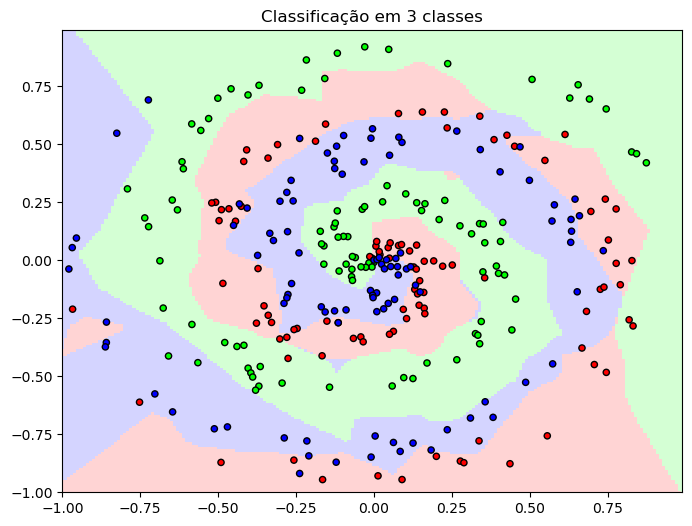

In [139]:
from matplotlib.colors import ListedColormap

def predict(x):
    dense1_outputs = dense1.forward(x)
    relu_outputs = relu.forward(dense1_outputs)
    dense2_outputs = dense2.forward(relu_outputs)
    softmax_outputs = softmax.forward(dense2_outputs)

    return softmax_outputs


x_test, y_test = spiral_data(samples=100, classes=3)
outputs = predict(x_test)
y_pred = np.argmax(outputs, axis=1)

h = 0.01
x_min, x_max = -1, 1
y_min, y_max = -1, 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

outputs = predict(np.c_[xx.ravel(), yy.ravel()])
z = np.argmax(outputs, axis=1)
z = z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, z, cmap=cmap_light, alpha=0.5)

plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(f"Classificação em 3 classes")
plt.show()